<a href="https://colab.research.google.com/github/joenvihe/ejemplos_machine_learning/blob/master/bernier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Predicción de Cantidad de Productos por Mes**

**Paso 1 :** Cargamos el dataset

In [0]:
# Load the Drive helper and mount
from google.colab import drive
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd /content/drive/'My Drive'/personal/PRACTICAS

/content/drive/My Drive/personal/PRACTICAS


In [5]:
!ls

bernier.ipynb  dataset_ventas.csv


**Paso 2 :** Identificamos el producto a analizar

In [0]:
NAME_PRODUCT = 'PRODUCTO_ABC1'

In [0]:
df = pd.read_csv("dataset_ventas.csv", parse_dates=[['year', 'month','day']])
df = df[['year_month_day',NAME_PRODUCT,'precipitacion','T_Max','TMR','Tasa_de_empleo','Tasa_de_desempleo','IPC']]
df = df.sort_values('year_month_day')
df_cant = df[['year_month_day',NAME_PRODUCT]]

In [267]:
df.head()

,year_month_day,PRODUCTO_ABC1,precipitacion,T_Max,TMR,Tasa_de_empleo,Tasa_de_desempleo,IPC
0,2015-01-31,250,3.156942,29.172795,2397.258065,56.940000,10.790000,83.000000
1,2015-02-28,100,3.004736,29.596166,2420.672500,57.390000,9.860000,83.000000
2,2015-03-31,812,3.990954,28.515759,2502.600645,56.351613,8.574194,81.290323
3,2015-04-30,816,5.202246,29.301018,2505.248000,59.270000,9.500000,84.000000
4,2015-05-31,1414,4.925526,29.372333,2437.535161,58.810000,8.930000,85.000000


In [0]:
df.set_index('year_month_day', inplace=True)

### **Time Series Forescasting**

**Paso 3 :** Solo se analiza la variacion de la cantidad del producto

In [269]:
df_cant.set_index('year_month_day', inplace=True)
df_cant.head()

,PRODUCTO_ABC1
year_month_day,
2015-01-31,250
2015-02-28,100
2015-03-31,812
2015-04-30,816
2015-05-31,1414


**Paso 4 :** Se visualiza la variación de la cantidad del producto en el tiempo

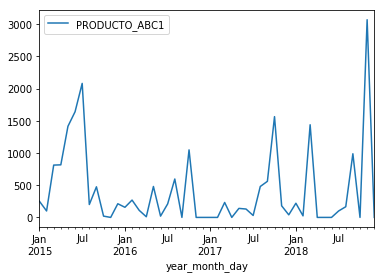

In [270]:
df_cant.plot()

**Paso 5 :** Se analiza la descomposición estacional de las cantidades utilizando medias móviles.

In [0]:
ts = pd.Series(list(df_cant[NAME_PRODUCT]), index=pd.to_datetime(df_cant.index,format='%Y-%m-%d')) 

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

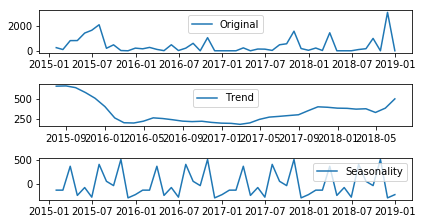

In [273]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()

In [274]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# log transform
ts_log = np.log(ts)
ts_log = ts_log.replace([np.inf, -np.inf], np.nan)
ts_log.dropna(inplace=True) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


### **Checking for Stationary**

**Paso 6 :** Validamos la estacionalidad utilizando el metodo adfuller, se realiza un grafico mostrando la estacionalidad.

Log transform stationary check p value:  5.0641233344138186e-05
Stationary
First order difference stationary check p value:  1.0977513770150992e-18


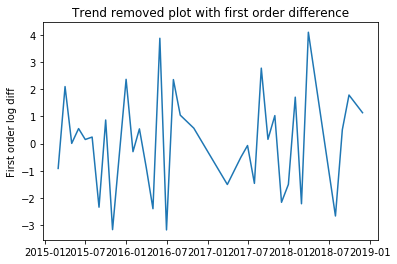

In [275]:
s_test = adfuller(ts_log, autolag='AIC')

#p,d,q  
# p = periods taken for autoregressive model
# d = Integrated order, difference
# q = periods in moving average model

print("Log transform stationary check p value: ", s_test[1])
if s_test[1] > 0.05:
  print("Non stationary")
else:
  print("Stationary")

#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.title('Trend removed plot with first order difference') 
plt.plot(ts_log_diff)
plt.ylabel('First order log diff')
s_test = adfuller(ts_log_diff, autolag='AIC')
print("First order difference stationary check p value: ", s_test[1])

### **Check autocorrelation**

**Paso 7 :** Validamos la autocorrelación en los tiempos de series 

Text(0.5, 0, 'Lags')

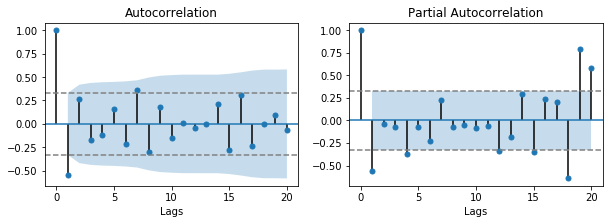

In [276]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
# ACF chart
fig = plot_acf(ts_log_diff.values.squeeze(), lags=20,ax=ax1)
# draw 95% confidence interval line
ax1.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.set_xlabel('Lags')
# PACF chart
fig = plot_pacf(ts_log_diff, lags=20, ax=ax2)
# draw 95% confidence interval line
ax2.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.set_xlabel('Lags')

**Paso 8** : Se calcula el modelo ARIMA

In [277]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
# build model
model = ARIMA(ts_log, order=(3,0,2)) 
results_ARIMA = model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


**Paso 9** : Se visualiza la cantidad Acual y Predicha

AIC:  135.86429557603535
BIC:  146.9489281452281


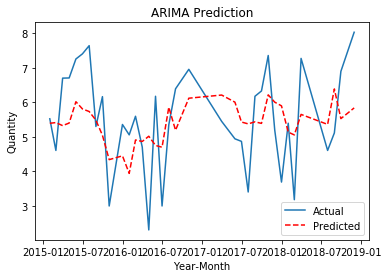

In [278]:
ts_predict = results_ARIMA.predict()
plt.title('ARIMA Prediction')
plt.plot(ts_log, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Quantity')
plt.legend(loc='best')
print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic) 

In [279]:
from statsmodels.stats.stattools import durbin_watson

print("Mean Absolute Error: ", mean_absolute_error(ts_log.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(ts_log.values,ts_predict.values)))
print("Durbin-Watson statistic :", durbin_watson(results_ARIMA.resid.values))

Mean Absolute Error:  1.1612693712226618
Root Mean Squared Error:  1.3080285090906414
Durbin-Watson statistic : 1.89045980985406


**Paso 10**: Se realiza la predicción para el periodo de un año

In [280]:
# predict future values 
model = ARIMA(ts_log, order=(3,0,2))
results_ARIMA = model.fit(disp=-1)
ts_predict = results_ARIMA.predict(start=36,end=48)
date_rng = pd.date_range(start='1/12/2018', end='1/1/2021', freq='M')
ts_predict.index = date_rng[11:24]  # solo el año 2019

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [281]:
for i,val in ts_predict.iteritems():
  print("En la fecha: {} la cantidad es {} ".format(i,str(round(np.exp([val])[0],2))))

En la fecha: 2018-12-31 00:00:00 la cantidad es 425.52 
En la fecha: 2019-01-31 00:00:00 la cantidad es 332.52 
En la fecha: 2019-02-28 00:00:00 la cantidad es 141.57 
En la fecha: 2019-03-31 00:00:00 la cantidad es 124.79 
En la fecha: 2019-04-30 00:00:00 la cantidad es 103.89 
En la fecha: 2019-05-31 00:00:00 la cantidad es 116.32 
En la fecha: 2019-06-30 00:00:00 la cantidad es 130.62 
En la fecha: 2019-07-31 00:00:00 la cantidad es 158.39 
En la fecha: 2019-08-31 00:00:00 la cantidad es 185.55 
En la fecha: 2019-09-30 00:00:00 la cantidad es 213.31 
En la fecha: 2019-10-31 00:00:00 la cantidad es 233.02 
En la fecha: 2019-11-30 00:00:00 la cantidad es 245.02 
En la fecha: 2019-12-31 00:00:00 la cantidad es 248.12 


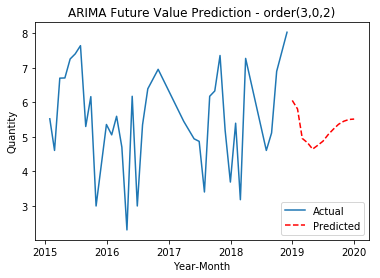

In [282]:
plt.title('ARIMA Future Value Prediction - order(3,0,2)')
plt.plot(ts_log, label='Actual')
plt.plot(ts_predict, 'r--', label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Quantity')
plt.legend(loc='best')

## **Predicción de Cantidad de Productos por Mes con variables dependientes**

In [0]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

**Paso 1**: Se desarrollo un metodo para transformar el dataset de tiempos de serie a uno supervisado

In [0]:
#convert data to supervised form

def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [287]:
data = df
data.head()

,PRODUCTO_ABC1,precipitacion,T_Max,TMR,Tasa_de_empleo,Tasa_de_desempleo,IPC
year_month_day,,,,,,,
2015-01-31,250,3.156942,29.172795,2397.258065,56.940000,10.790000,83.000000
2015-02-28,100,3.004736,29.596166,2420.672500,57.390000,9.860000,83.000000
2015-03-31,812,3.990954,28.515759,2502.600645,56.351613,8.574194,81.290323
2015-04-30,816,5.202246,29.301018,2505.248000,59.270000,9.500000,84.000000
2015-05-31,1414,4.925526,29.372333,2437.535161,58.810000,8.930000,85.000000


**Paso 2:** Se realiza un analisis de las variables dependientes

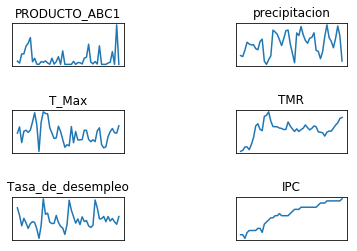

In [288]:
groups = [0, 1, 2, 3, 5, 6]
values = data.values
fig,sub = plt.subplots(3,2)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(data.columns[i])

In [289]:
values = data.values
values[:2]

array([[ 250.        ,    3.1569425 ,   29.17279486, 2397.258065  ,
          56.94      ,   10.79      ,   83.        ],
       [ 100.        ,    3.00473603,   29.59616634, 2420.6725    ,
          57.39      ,    9.86      ,   83.        ]])

**Paso 3:**  Se transsforma las variables a una medida scalar entre 0 y 1

In [290]:
# integer encode direction
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled[:2]

array([[0.08148631, 0.2229397 , 0.4618063 , 0.        , 0.20320892,
        0.7706015 , 0.09137917],
       [0.03259452, 0.19788739, 0.6172409 , 0.02444887, 0.28342247,
        0.58011866, 0.09137917]], dtype=float32)

**Paso 4 :** Se genera el dataset para un modelo supervisado

In [302]:
# frame as supervised learning 
supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()


,0,1,2,3,4,5,6,7
0,0.081486,0.222940,0.461806,0.000000,0.203209,0.770602,0.091379,0.032595
1,0.032595,0.197887,0.617241,0.024449,0.283422,0.580119,0.091379,0.264668
2,0.264668,0.360213,0.220586,0.109996,0.098327,0.316760,0.000000,0.265971
3,0.265971,0.559585,0.508882,0.112760,0.618539,0.506384,0.144827,0.460887
4,0.460887,0.514038,0.535064,0.042056,0.536542,0.389636,0.198276,0.534550


**Paso 5:** Se genera los datos de test y de entranamiento

In [292]:
features = data.shape[1]
train_hours = 35
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]

x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(35, 7) (12, 7) (35,) (12,)


In [293]:
x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print(x_train.shape,x_test.shape)

(35, 1, 7) (12, 1, 7)


**Paso 6:** Se define y ejecuta el modelo 

In [0]:
#define the model

model = Sequential()
model.add( LSTM( 50, input_shape = ( timeSteps,x_train.shape[2]) ) )
model.add( Dense(1) )

model.compile( loss = "mae", optimizer = "adam")

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 50 , batch_size = 72, verbose = 0, shuffle = False)

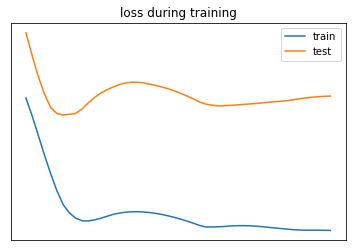

In [295]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

**Paso 7:** Se valida el resultado

In [0]:
#scale back the prediction to orginal scale
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1]) 

In [0]:
inv_new = np.concatenate( (y_pred, x_test[:,1:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]

In [0]:
y_test = y_test.reshape( len(y_test), 1)
inv_new = np.concatenate( (y_test, x_test[:,1:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

In [299]:
final_pred

array([134.34682 , 192.35939 , 213.56529 , 261.5856  , 134.30728 ,
       106.517914, 113.360794, 163.02943 , 175.67087 , 212.30632 ,
       135.40186 , 259.74493 ], dtype=float32)

In [300]:
actual_pred

array([ 219.99998,   24.     , 1438.     ,    0.     ,    0.     ,
          0.     ,  100.     ,  166.     ,  987.99994,    0.     ,
       3068.     ,    0.     ], dtype=float32)

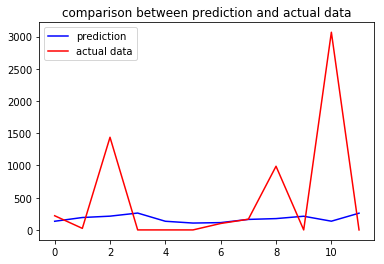

In [301]:
plt.plot(final_pred, label = "prediction",c = "b")
plt.plot(actual_pred,label = "actual data",c="r")
plt.title("comparison between prediction and actual data")
plt.legend()